# Vaja 3

### Zakaj uporabljamo Ridge in Lasso regresijo?

Ridge regresija (L2 regularizacija) pomaga preprečiti overfitting z zmanjšanjem koeficientov, kar je uporabno, ko so vse značilke pomembne. Lasso regresija (L1 regularizacija) ne samo zmanjšuje koeficiente, ampak lahko tudi nekatere postavi na nič, kar omogoča izbiro značilk.

 Uporabite Ridge, ko želite obdržati vse značilnke, in Lasso, ko želimo poenostaviti model z izbiro samo najpomembnejših značilnosti.

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt
import ssl
import requests
from scipy.stats import linregress
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import time

### Priprava podatkov
Naložimo dataset **Communities and Crime**, odstranimo nepotrebne stolpce ter premešamo podatke.

- **Odstranjevanje stolpcev**: odstranimo stolpce, ki niso relevantni za modeliranje (`state`, `county`, `community`, `communityname`, `fold`).
- **Premešanje podatkov**: premešamo podatke z `random_state=88` za reprodukcijo rezultatov.


In [14]:
attributes = pd.read_csv('communities+and+crime/attributes.txt')
data = pd.read_csv('communities+and+crime/communities.data', names=attributes['attributes'])
data.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], inplace=True)
data = data.sample(frac=1, random_state=88).reset_index(drop=True)

### Obdelava manjkajočih podatkov
Preverimo manjkajoče vrednosti in odstranimo atribute z visokim odstotkom manjkajočih podatkov.

- **Prag za odstranjevanje**: odstranimo atribute, kjer je več kot 20% vrednosti manjkajočih.
- **Nadomeščanje manjkajočih vrednosti**: preostale manjkajoče vrednosti nadomestimo s povprečjem posameznega atributa.

In [15]:
treshold = 20
question_mark_percentage = (data.isin(['?']).sum() / len(data)) * 100
to_remove = question_mark_percentage[question_mark_percentage > treshold]
data.drop(columns=to_remove.index.to_list(), inplace=True)
data.replace('?', np.nan, inplace=True)
for i in data.columns:
    data[i] = data[i].astype(float)    
    data[i] = data[i].fillna(data[i].mean())

### Razdelitev podatkov na učne in testne nabore
Podatke razdelimo na učne in testne nabore.

- **Ciljna spremenljivka**: `ViolentCrimesPerPop`.
- **Lastnosti**: preostali atributi po čiščenju podatkov.
- **Razmerje razdelitve**: 90% učni podatki, 10% testni podatki.
Baje da je takšno razmerje najboljše


In [16]:
X = data.drop(columns=['ViolentCrimesPerPop'])
y = data['ViolentCrimesPerPop']
split_ratio = 0.9
split_index = int(len(data) * split_ratio) 
train_X = X.iloc[:split_index]
test_X = X.iloc[split_index:]
train_y = y.iloc[:split_index]
test_y = y.iloc[split_index:]

### Ridge regresija z RidgeCV
Uporabimo `RidgeCV` iz knjižnice Scikit-learn za iskanje optimalnega parametra `alpha`.

dobra vrednost `alpha` je 0.1

- **Parametri `alpha`**: preizkusimo vrednosti `[0.01, 0.1, 0.5, 0.8]`.
- **Navzkrižna validacija**: avtomatsko izbere najboljši `alpha` na podlagi minimalnega MSE.
- **Ocena modela**: izračunamo MSE, MAE in $R^2$ na testnem naboru.


In [17]:
alphas = [0.05, 0.1, 0.2, 0.8, 0.9,0.99,1,5]
model_ridge = RidgeCV(alphas)

model_ridge.fit(train_X, train_y)
selected_alpha = model_ridge.alpha_
print(f"Selected alpha: {selected_alpha}")
pred_y = model_ridge.predict(test_X)
mse_ridge = mean_squared_error(test_y, pred_y)
mae_ridge = mean_absolute_error(test_y, pred_y)
r2_ridge = r2_score(test_y, pred_y)
print("Ridge results\nMSE = {}\nMAE = {}\nR^2 = {}".format(mse_ridge, mae_ridge, r2_ridge))

Selected alpha: 0.99
Ridge results
MSE = 0.02101501950442059
MAE = 0.10561406999626957
R^2 = 0.6572768883474194


### Lasso regresija z LassoCV
Uporabimo `LassoCV` za iskanje optimalnega parametra `alpha` in izvedemo Lasso regresijo.

- **Parametri `alpha`**: uporabimo iste vrednosti kot pri Ridge regresiji.
- **Navzkrižna validacija**: izberemo najboljši `alpha` s pomočjo 10-kratne navzkrižne validacije.
- **Analiza koeficientov**: preverimo, kateri atributi so bili izločeni zaradi L1 regularizacije.


In [18]:
model_lasso = LassoCV(alphas=alphas, cv=10)
model_lasso.fit(train_X, train_y)
pred_y = model_lasso.predict(test_X)
mse_lasso = mean_squared_error(test_y, pred_y)
mae_lasso = mean_absolute_error(test_y, pred_y)
r2_lasso = r2_score(test_y, pred_y)
print("Lasso results\nMSE = {}\nMAE = {}\nR^2 = {}".format(mse_lasso, mae_lasso, r2_lasso))

Lasso results
MSE = 0.06265262893591794
MAE = 0.18294030100334452
R^2 = -0.021769403431459056




### Primerjava

1. **Mean Squared Error (MSE)**:
   - Ridge Regression  boljš

2. **Mean Absolute Error (MAE)**:
   - Ridge Regression boljš

3. **R² Score**:
   - explanatory power
   - Lasso slab, negativen

### Implementacija Ridge regresije z Gradient Descent (Batch Gradient Descent)

Implementacija Ridge regresije z Batch Gradient Descent omogoča učinkovito treniranje modela z uporabo celotnega nabora podatkov v vsaki iteraciji. Ta metoda je stabilna in natančna, še posebej pri uporabi skaliranih značilnk in ustreznih hiperparametrov.


In [19]:
# Load and prepare the dataset
data = pd.read_csv('wine+quality/winequality-white.csv', delimiter=';')
X = data.drop('quality', axis=1).values
y = data['quality'].values.reshape(-1, 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define learning rates to test (reduced to avoid overflow)
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]

# Initialize a list to store results
results = []


In [20]:
class RidgeRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=10000, regularization_param=0.8, tolerance=1e-4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_ = regularization_param
        self.tolerance = tolerance
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        self.theta = np.zeros((n + 1, 1))
        previous_cost = float('inf')
        for iteration in range(self.n_iterations):
            predictions = X_b @ self.theta
            errors = predictions - y
            gradient = (1 / m) * (X_b.T @ errors) + (self.lambda_ / m) * np.r_[[[0]], self.theta[1:]]
            self.theta -= self.learning_rate * gradient
            mse = (1 / (2 * m)) * np.sum(errors ** 2)
            L2_reg = (self.lambda_ / (2 * m)) * np.sum(self.theta[1:] ** 2)
            cost = mse + L2_reg
            if abs(previous_cost - cost) < self.tolerance:
                self.n_iterations = iteration + 1
                break
            previous_cost = cost

    def predict(self, X):
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return X_b @ self.theta

In [21]:
# Test Batch Gradient Descent with different learning rates
for lr in learning_rates:
    model_gd = RidgeRegressionGD(learning_rate=lr, n_iterations=10000, regularization_param=0.8, tolerance=1e-4)
    start_time = time.time()
    model_gd.fit(train_X, train_y)
    end_time = time.time()
    pred_y = model_gd.predict(test_X)
    mse = mean_squared_error(test_y, pred_y)
    mae = mean_absolute_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)
    results.append({
        'Method': 'Batch GD',
        'Learning Rate': lr,
        'Iterations': model_gd.n_iterations,
        'Time (s)': end_time - start_time,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

### Ridge regresija s Stohastičnim Gradientnim Spustom
Implementiramo Ridge regresijo z uporabo Stohastičnega Gradientnega Spusta.

- **Algoritem**: posodabljamo koeficiente na podlagi posameznih primerov.
- **Prednosti**: hitrejša konvergenca in boljša pri delu z velikimi podatkovnimi nizi.
- **Nastavitve**: prilagodimo učno stopnjo in število iteracij glede na velikost podatkov.


In [ ]:
class RidgeRegressionSGD:
    def __init__(self, learning_rate=0.00001, n_iterations=1000, regularization_param=0.8, tolerance=1e-4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_ = regularization_param
        self.tolerance = tolerance
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.bias = 0.0
        self.weights = np.zeros((n_features, 1))
        previous_cost = float('inf')
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(n_samples)
            for idx in indices:
                xi = X[idx].reshape(1, -1)
                yi = y[idx]
                y_pred = np.dot(xi, self.weights) + self.bias
                error = y_pred - yi
                gradient_weights = xi.T * error + (self.lambda_ * self.weights)
                gradient_bias = error
                self.weights -= self.learning_rate * gradient_weights
                self.bias -= self.learning_rate * gradient_bias
            
            #ridge
            y_pred_total = np.dot(X, self.weights) + self.bias
            mse = (1 / (2 * n_samples)) * np.sum((y_pred_total - y) ** 2)
            L2_reg = (self.lambda_ / (2 * n_samples)) * np.sum(self.weights ** 2)
            cost = mse + L2_reg
            
            if abs(previous_cost - cost) < self.tolerance:
                self.n_iterations = iteration + 1
                print(f"Converged after {iteration+1} iterations with cost: {cost:.6f}")
                break
            previous_cost = cost

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

Converged after 15 iterations with cost: 0.307209
Converged after 3 iterations with cost: 0.308452
Converged after 225 iterations with cost: 0.309155
Converged after 726 iterations with cost: 0.395305
Comparison of Batch GD and SGD with Different Learning Rates:



,Method,Learning Rate,Iterations,Time (s),MSE,MAE,R2
0,Batch GD,0.0001,10000,0.946155,5.383375,2.191995,-5.951016
1,Batch GD,0.0010,2941,0.312685,0.682827,0.634917,0.118334
2,Batch GD,0.0100,413,0.041431,0.587674,0.592351,0.241195
3,Batch GD,0.0500,100,0.007013,0.579082,0.590448,0.252289
4,Batch GD,0.1000,54,0.003951,0.578060,0.590572,0.253609
5,SGD,0.0001,15,0.815727,0.610066,0.606400,0.212283
6,SGD,0.0010,3,0.141779,0.618086,0.606301,0.201927
7,SGD,0.0100,225,11.176459,0.602111,0.609263,0.222554
8,SGD,0.0500,726,36.736621,0.785812,0.689459,-0.014640
9,SGD,0.1000,1000,47.830225,1.949451,1.076520,-1.517132


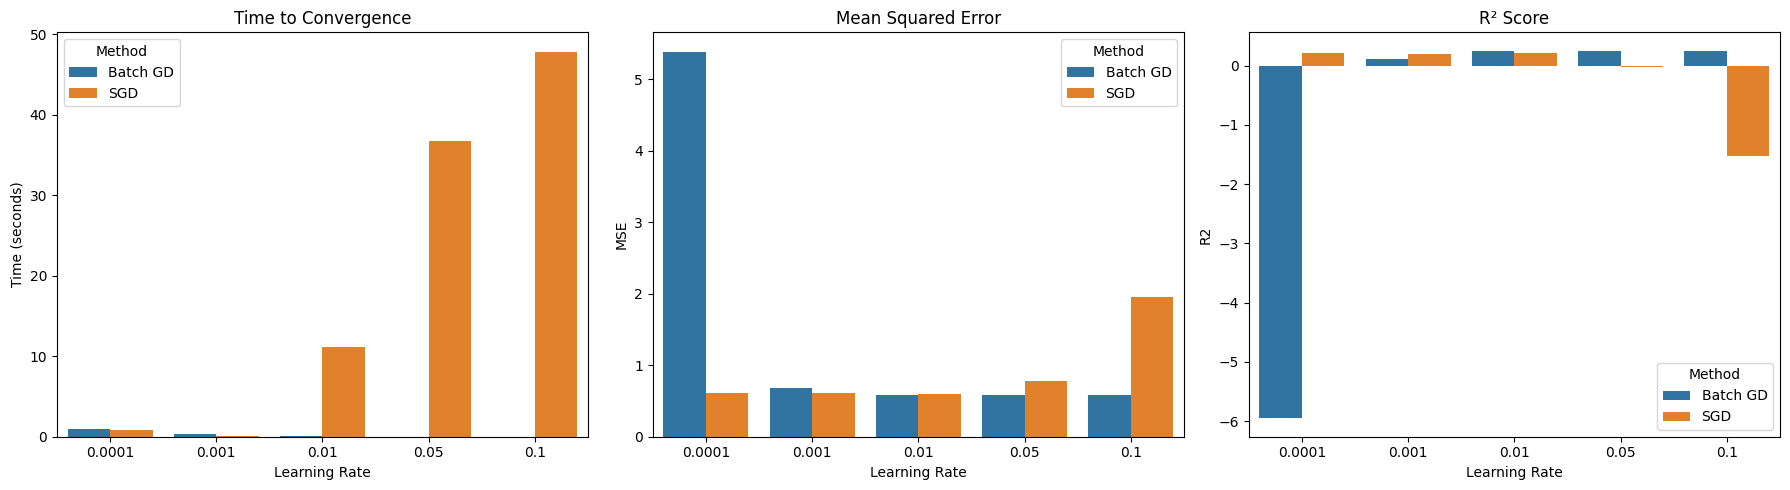

In [23]:
# Test Stochastic Gradient Descent with different learning rates
for lr in learning_rates:
    model_sgd = RidgeRegressionSGD(learning_rate=lr, n_iterations=1000, regularization_param=0.8, tolerance=1e-4)
    start_time = time.time()
    model_sgd.fit(train_X, train_y)
    end_time = time.time()
    pred_y = model_sgd.predict(test_X)
    mse = mean_squared_error(test_y, pred_y)
    mae = mean_absolute_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)
    results.append({
        'Method': 'SGD',
        'Learning Rate': lr,
        'Iterations': model_sgd.n_iterations,
        'Time (s)': end_time - start_time,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("Comparison of Batch GD and SGD with Different Learning Rates:\n")
display(results_df)

# Visualize the results
plt.figure(figsize=(18, 5))

# Plot Time (s)
plt.subplot(1, 3, 1)
sb.barplot(data=results_df, x='Learning Rate', y='Time (s)', hue='Method')
plt.title('Time to Convergence')
plt.ylabel('Time (seconds)')

# Plot MSE
plt.subplot(1, 3, 2)
sb.barplot(data=results_df, x='Learning Rate', y='MSE', hue='Method')
plt.title('Mean Squared Error')

# Plot R² Score
plt.subplot(1, 3, 3)
sb.barplot(data=results_df, x='Learning Rate', y='R2', hue='Method')
plt.title('R² Score')

plt.tight_layout()
plt.show()

#### Optimalen Learning Rate - Batch GD: 0.1

Iterations: 54
Time: 0.004 seconds
MSE: 0.578
MAE: 0.591
R²: 0.25 

#### Optimalen Learning Rate - SGD: 0.0001
Iterations: 19
Time: 1.059 seconds
MSE: 0.609
MAE: 0.606
R²: 0.21 